In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import assembly_multi_region, assembly_multi_region_pos_maps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import glob
import pickle
import itertools
from ripple_heterogeneity.place_cells import maps
from scipy import stats
from scipy.stats import zscore

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## locate tmaze sessions

In [21]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

epoch_df = pd.DataFrame()
for basepath in df.basepath.unique():

    epoch_df_ = loading.load_epoch(basepath)
    df_temp_regions = pd.DataFrame()
    df_temp_regions["regions"] = loading.load_brain_regions(basepath).keys()
    epoch_df_["mec"] = df_temp_regions.regions.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").any()
    epoch_df_["pfc"] = df_temp_regions.regions.str.contains("PFC").any()

    epoch_df_["basepath"] = basepath

    epoch_df = pd.concat([epoch_df,epoch_df_],ignore_index=True)


session_df = pd.DataFrame()
session_df["basepath"] = epoch_df.query("environment.str.contains('Mwheel|Tmaze|tmaze') & (mec|pfc)").basepath.unique()

In [ ]:
save_file = os.path.join(
    save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"

In [24]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt"


# sessions = glob.glob(save_path + os.sep + "*.pkl")
for basepath in session_df.basepath:
    save_file = os.path.join(save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl")
    if not os.path.exists(save_file):
        continue
    with open(save_file, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue
    _, assembly_df, keep_assembly = assembly_multi_region.compile_results_df(results)
    
    counts_df = (
        assembly_df.groupby(["assembly_n", "is_member_sig"])
        .apply(
            lambda x: pd.Series(
                {
                    "n_deep": (x.deepSuperficial == "Deep").sum(),
                    "n_sup": (x.deepSuperficial == "Superficial").sum(),
                    "n_mec": (
                        x.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")
                    ).sum(),
                    "n_pfc": (x.brainRegion.str.contains("PFC")).sum(),
                }
            )
        )
        .reset_index()
    )
    print(save_file)
    display(counts_df.query("is_member_sig"))

    # "Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_AYAold_AYA9_day12.pkl"

Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0622fm.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,2,0,0
3,1,True,0,0,0,13
5,2,True,2,2,0,0
7,3,True,0,3,0,0
9,4,True,1,2,0,0
11,5,True,1,3,0,0
13,6,True,1,3,0,0
15,7,True,1,2,0,1
17,8,True,1,2,0,0


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0627fm.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,1,0,0
3,1,True,0,0,0,5
5,2,True,3,1,0,0
7,3,True,0,0,0,6
9,4,True,2,0,0,1
11,5,True,1,0,0,7
13,6,True,0,1,0,0
15,7,True,2,1,0,0
17,8,True,0,0,0,11
19,9,True,1,3,0,0


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0705fm.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,7
3,1,True,0,0,0,3
5,2,True,2,0,0,1
7,3,True,5,0,0,0
9,4,True,3,0,0,8
11,5,True,0,0,0,4
13,6,True,5,1,0,3
15,7,True,0,1,0,3
17,8,True,0,1,0,5
19,9,True,3,2,0,1


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0706fm.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,2,0,1
3,1,True,0,0,0,2
5,2,True,0,0,0,4
7,3,True,1,0,0,5


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0708fm.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,5,0,0,0
3,1,True,1,0,0,5
5,2,True,4,0,0,1
7,3,True,4,0,0,0
9,4,True,0,0,0,0
11,5,True,3,0,0,0
13,6,True,0,0,0,2


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0710.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,5
3,1,True,0,0,0,5
5,2,True,0,0,0,4
7,3,True,1,0,0,3
9,4,True,0,0,0,4
11,5,True,0,0,0,10
13,6,True,0,0,0,3
15,7,True,0,0,0,2
17,8,True,0,0,0,7
19,9,True,0,0,0,6


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0711.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,3,0,0
3,1,True,0,1,0,0
5,2,True,0,0,0,4
7,3,True,0,0,0,6
9,4,True,0,0,0,6
11,5,True,0,0,0,2
13,6,True,0,0,0,0
15,7,True,0,0,0,7
17,8,True,0,0,0,0
19,9,True,0,1,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_FF_FF1114.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,0,0
3,1,True,0,0,0,9
5,2,True,0,0,0,3
7,3,True,2,0,0,1
9,4,True,0,0,0,3


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_FF_FF1116.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,3
3,1,True,0,0,0,4
5,2,True,0,0,0,4
7,3,True,0,0,0,5
9,4,True,0,0,0,3
11,5,True,0,0,0,4


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_FF_FF1119.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,2
3,1,True,0,3,0,2
5,2,True,0,1,0,0
7,3,True,0,1,0,2
9,4,True,0,0,0,3


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_GG_GG0401.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,0,0
3,1,True,3,0,0,5
5,2,True,2,1,0,0
7,3,True,1,0,0,5
9,4,True,1,0,0,5
11,5,True,1,0,0,1
13,6,True,0,0,0,3


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_GG_GG0406.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,1,0,0
3,1,True,0,0,0,2
5,2,True,0,2,0,0
7,3,True,0,4,0,1
9,4,True,0,0,0,8
11,5,True,0,1,0,2
13,6,True,0,2,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.421_447.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,3,0,0
3,1,True,4,0,0,0
5,2,True,2,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.480_509.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,2,0
3,1,True,2,0,0,0
5,2,True,3,0,0,0
7,3,True,0,0,4,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.540_561.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,1,0
3,1,True,0,0,5,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.608_632.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,3,0,0,0
3,1,True,4,0,0,0
5,2,True,1,0,4,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.656_674.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,1,1,0
3,1,True,0,3,0,0
5,2,True,1,2,0,0
7,3,True,0,4,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.702_724.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,2,0,0,0
3,1,True,2,1,0,0
5,2,True,2,0,0,0
7,3,True,1,1,0,0
9,4,True,0,1,0,0
11,5,True,0,1,4,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.771_777.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,0
3,1,True,1,1,0,0
5,2,True,0,3,0,0
7,3,True,0,1,0,0
9,4,True,0,0,0,0
11,5,True,0,0,0,0
13,6,True,0,0,0,0
15,7,True,0,2,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.779_791.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,0
3,1,True,0,0,0,0
5,2,True,0,0,3,0
7,3,True,2,0,0,0
9,4,True,0,2,0,0
11,5,True,0,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.816_835.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,1,0,0
3,1,True,0,0,0,0
5,2,True,0,0,0,0
7,3,True,0,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.895_902.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,5,0
3,1,True,0,0,2,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec013.921_927.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,1,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.120_130.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,2,0
3,1,True,1,0,2,0
5,2,True,0,0,2,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.133_141.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,3,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.171_188.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,1,0
3,1,True,3,1,0,0
5,2,True,1,0,0,0
7,3,True,2,0,0,0
9,4,True,2,0,0,0
11,5,True,1,0,0,0
13,6,True,0,0,0,0
15,7,True,0,1,0,0
17,8,True,0,0,3,0
19,9,True,1,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.192_204.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,3,0,0,0
3,1,True,0,0,1,0
5,2,True,2,0,0,0
7,3,True,0,1,1,0
9,4,True,1,0,0,0
11,5,True,3,0,0,0
13,6,True,0,1,0,0
15,7,True,0,0,0,0
17,8,True,1,0,0,0
19,9,True,1,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.345_366.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,2,0,0
3,1,True,2,0,0,0
5,2,True,0,0,0,0
7,3,True,0,0,0,0
9,4,True,3,0,0,0
11,5,True,0,1,0,0
13,6,True,1,0,0,0
15,7,True,1,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.370_396.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,3,0,0,0
3,1,True,0,0,5,0
5,2,True,3,0,0,0
7,3,True,3,0,0,0
9,4,True,3,0,0,0
11,5,True,2,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.398_425.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,3,0
3,1,True,2,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec014.427_456.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,2,1,0,0
3,1,True,0,0,0,0
5,2,True,3,0,0,0
7,3,True,2,0,2,0
9,4,True,6,0,0,0
11,5,True,3,0,0,0
13,6,True,3,0,0,0
15,7,True,3,0,0,0
17,8,True,0,0,2,0
19,9,True,1,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.444_459.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,0
3,1,True,1,1,0,0
5,2,True,0,2,1,0
7,3,True,0,1,0,0
9,4,True,0,4,0,0
11,5,True,0,0,0,0
13,6,True,1,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.479_487.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,1,0,0
3,1,True,0,0,0,0
5,2,True,2,0,0,0
7,3,True,0,2,0,0
9,4,True,0,2,0,0
11,5,True,0,1,0,0
13,6,True,1,1,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.491_508.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,1,0,0
3,1,True,0,8,0,0
5,2,True,0,1,0,0
7,3,True,0,1,0,0
9,4,True,0,1,0,0
11,5,True,1,0,0,0
13,6,True,1,2,0,0
15,7,True,1,1,0,0
17,8,True,0,1,0,0
19,9,True,2,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.532_540.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,1,0,0
3,1,True,0,2,1,0
5,2,True,0,1,0,0
7,3,True,0,3,0,0
9,4,True,0,1,1,0
11,5,True,1,1,0,0
13,6,True,2,1,0,0
15,7,True,0,0,0,0
17,8,True,0,1,0,0
19,9,True,0,0,1,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.659_674.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,3,0


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.769_789.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,2,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.835_850.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,1,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_ec016.950_965.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,1,0


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_i01_maze01_MS.001_003.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,3,1,0
3,1,True,0,3,0,0
5,2,True,0,1,2,0
7,3,True,0,2,0,0


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_i01_maze02_MS.001_003.pkl


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,2,0,0
3,1,True,0,3,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_i01_maze04_MS.001_003.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,2,0,0,0
3,1,True,1,0,0,0
5,2,True,2,0,0,0
7,3,True,1,0,0,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_i01_maze05_MS.001_003.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,0,0,0
3,1,True,1,0,0,0
5,2,True,1,0,0,0
7,3,True,1,0,0,0
9,4,True,2,0,0,0
11,5,True,1,0,1,0
13,6,True,0,1,0,0
15,7,True,2,0,0,0
17,8,True,1,0,0,0
19,9,True,0,1,2,0


Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_Kenji_i01_maze15_MS.001_004.pkl


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,0,0,0,0
3,1,True,0,0,0,0
5,2,True,0,0,0,0
7,3,True,1,0,0,0
9,4,True,1,1,0,0
11,5,True,1,0,0,0
13,6,True,0,0,0,0
15,7,True,0,0,0,0
17,8,True,0,0,0,0
19,9,True,1,0,0,0


In [25]:
# basepath = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0622fm.pkl"
# basepath = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0705fm.pkl"
basepath = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_FujisawaS_EE_EE0627fm.pkl"
with open(basepath, "rb") as f:
    results = pickle.load(f)

In [26]:
position_df = loading.load_animal_behavior(results['react'].basepath)


In [27]:
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")

pos = nel.PositionArray(data=position_df_no_nan[["x","y"]].values.T,timestamps=position_df_no_nan.timestamps.values)

In [28]:
results["react"].epoch_df

,name,startTime,stopTime,environment,behavioralParadigm
2,EE.084,3743.6768,6738.3504,sleep,NaN
3,EE.088,6738.3504,8903.496,tmaze,Working memory task
4,EE.089,8903.496,10961.3264,sleep,NaN


In [29]:
results["react"].z_mat_dt = 0.05
assembly_act_task = results["react"].get_assembly_act(epoch=results["react"].epochs[1])


In [31]:
pos = pos[results["react"].epochs[1]]

In [19]:
tc_other_method = maps.TuningCurve2DContinuous(asa=assembly_act_task, pos=pos,sigma=3)


In [32]:
_, assembly_df, keep_assembly = assembly_multi_region.compile_results_df(results)
assembly_df

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
0,0.027566,False,0,1,Pyramidal Cell,PFC,unknown,NaN
1,-0.072095,False,0,3,Pyramidal Cell,PFC,unknown,NaN
2,0.031565,False,0,5,Pyramidal Cell,PFC,unknown,NaN
3,0.010660,False,0,6,Pyramidal Cell,PFC,unknown,NaN
4,0.080487,False,0,7,Pyramidal Cell,PFC,unknown,NaN
...,...,...,...,...,...,...,...,...
3451,-0.048659,False,17,317,Pyramidal Cell,CA1,Deep,-234.46635
3452,0.013960,False,17,322,Pyramidal Cell,CA1,Deep,-214.46635
3453,-0.003064,False,17,324,Pyramidal Cell,CA1,Deep,-234.46635
3454,-0.027435,False,17,325,Pyramidal Cell,CA1,Deep,-194.46635


In [33]:
counts_df = (
    assembly_df.groupby(["assembly_n", "is_member_sig"])
    .apply(
        lambda x: pd.Series(
            {
                "n_deep": (x.deepSuperficial == "Deep").sum(),
                "n_sup": (x.deepSuperficial == "Superficial").sum(),
                "n_mec": (
                    x.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")
                ).sum(),
                "n_pfc": (x.brainRegion.str.contains("PFC")).sum(),
            }
        )
    )
    .reset_index()
)
counts_df.query("is_member_sig")

,assembly_n,is_member_sig,n_deep,n_sup,n_mec,n_pfc
1,0,True,1,1,0,0
3,1,True,0,0,0,5
5,2,True,3,1,0,0
7,3,True,0,0,0,6
9,4,True,2,0,0,1
11,5,True,1,0,0,7
13,6,True,0,1,0,0
15,7,True,2,1,0,0
17,8,True,0,0,0,11
19,9,True,1,3,0,0


In [41]:
assembly_df.query("assembly_n == 5 & is_member_sig")

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
1033,0.259263,True,5,117,Pyramidal Cell,PFC,unknown,NaN
1045,0.206001,True,5,146,Pyramidal Cell,PFC,unknown,NaN
1051,0.438451,True,5,159,Pyramidal Cell,PFC,unknown,NaN
1054,0.157734,True,5,166,Pyramidal Cell,PFC,unknown,NaN
1056,0.292442,True,5,172,Pyramidal Cell,PFC,unknown,NaN
1060,0.357171,True,5,178,Pyramidal Cell,PFC,unknown,NaN
1062,0.182618,True,5,181,Pyramidal Cell,PFC,unknown,NaN
1076,0.214896,True,5,214,Pyramidal Cell,CA1,Deep,-31.375549
1140,0.155623,True,5,303,Pyramidal Cell,CA1,middle,23.063335


In [35]:
tc_unit = maps.SpatialMap(pos=pos,st=results["react"].st,dim=2)

In [35]:
import pynapple as nap
from scipy.ndimage import gaussian_filter


def get_2d_tuning_curves_continous(
    pos,
    asa,
    smooth_sigma=1,
    s_binsize=2,
    speed_thres=4,
):

    ext_xmin, ext_xmax = (
        np.floor(pos.data[0].min() / 10) * 10,
        np.ceil(pos.data[0].max() / 10) * 10,
    )
    ext_ymin, ext_ymax = (
        np.floor(pos.data[1].min() / 10) * 10,
        np.ceil(pos.data[1].max() / 10) * 10,
    )
    n_extern = int((ext_xmax - ext_xmin) / s_binsize)

    # compute and smooth speed
    speed1 = nel.utils.ddt_asa(pos, smooth=True, sigma=0.1, norm=True)

    # find epochs where the animal ran > 4cm/sec
    run_epochs = nel.utils.get_run_epochs(speed1, v1=speed_thres, v2=speed_thres)

    # add assembly activations to tsdframe object
    tsdframe = nap.TsdFrame(
        t=assembly_act_task[run_epochs].abscissa_vals,
        d=assembly_act_task[run_epochs].data.T,
    )

    # add position to tsd object
    feature = nap.TsdFrame(
        t=pos[run_epochs].abscissa_vals,
        d=pos[run_epochs].data.T,
    )

    # compute tuning curves
    tc, xy = nap.compute_2d_tuning_curves_continuous(
        tsdframe,
        feature,
        nb_bins=n_extern,
        minmax=[ext_xmin, ext_xmax, ext_ymin, ext_ymax],
    )
    # for tc_key in tc.keys():
    #     tc[tc_key] = gaussian_filter(tc[tc_key], sigma=smooth_sigma)
    # smooth
    # tc_ = tc_.rolling(
    #     window=smooth_window, win_type="gaussian", center=True, min_periods=1
    # ).mean(std=smooth_sigma)
    return tc, xy


def get_2d_tuning_curves(
    pos,
    st,
    smooth_sigma=1,
    s_binsize=2,
    speed_thres=4,
):
    ext_xmin, ext_xmax = (
        np.floor(pos.data[0].min() / 10) * 10,
        np.ceil(pos.data[0].max() / 10) * 10,
    )
    ext_ymin, ext_ymax = (
        np.floor(pos.data[1].min() / 10) * 10,
        np.ceil(pos.data[1].max() / 10) * 10,
    )
    n_extern = int((ext_xmax - ext_xmin) / s_binsize)

    # compute and smooth speed
    speed1 = nel.utils.ddt_asa(pos, smooth=True, sigma=0.1, norm=True)

    # find epochs where the animal ran > 4cm/sec
    run_epochs = nel.utils.get_run_epochs(speed1, v1=speed_thres, v2=speed_thres)

    my_ts = {}
    for st_i, st in enumerate(st.data):
        my_ts[st_i] = nap.Ts(t=st, time_units="s")
    tsgroup = nap.TsGroup(my_ts)

    # add position to tsd object
    feature = nap.TsdFrame(
        t=pos[run_epochs].abscissa_vals,
        d=pos[run_epochs].data.T,
    )

    tc, xy = nap.compute_2d_tuning_curves(
        tsgroup,
        feature,
        nb_bins=n_extern,
        minmax=[ext_xmin, ext_xmax, ext_ymin, ext_ymax],
    )

    for tc_key in tc.keys():
        current_map = tc[tc_key].copy()
        nan_locs = np.isnan(current_map)
        current_map[nan_locs] = 0
        tc[tc_key] = gaussian_filter(current_map, sigma=smooth_sigma)
        tc[tc_key][nan_locs] = np.nan

    return tc, xy


smooth_sigma = 1
s_binsize = 3
speed_thres = 3
tc_unit, xy = get_2d_tuning_curves(
    pos,
    results["react"].st,
    smooth_sigma=smooth_sigma,
    s_binsize=s_binsize,
    speed_thres=speed_thres,
)

tc_assembly, xy = get_2d_tuning_curves_continous(
    pos,
    assembly_act_task,
    smooth_sigma=smooth_sigma,
    s_binsize=s_binsize,
    speed_thres=speed_thres,
)

nan_locs = np.isnan(tc_unit[0])
for tc_key in tc_assembly.keys():
    tc_assembly[tc_key] = gaussian_filter(tc_assembly[tc_key], sigma=1)
    tc_assembly[tc_key][nan_locs] = np.nan


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\pynapple\process\tuning_curves.py:139: RuntimeWarning: invalid value encountered in true_divide


In [42]:
assembly_df.query("assembly_n == 5 & is_member_sig")

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
1033,0.259263,True,5,117,Pyramidal Cell,PFC,unknown,NaN
1045,0.206001,True,5,146,Pyramidal Cell,PFC,unknown,NaN
1051,0.438451,True,5,159,Pyramidal Cell,PFC,unknown,NaN
1054,0.157734,True,5,166,Pyramidal Cell,PFC,unknown,NaN
1056,0.292442,True,5,172,Pyramidal Cell,PFC,unknown,NaN
1060,0.357171,True,5,178,Pyramidal Cell,PFC,unknown,NaN
1062,0.182618,True,5,181,Pyramidal Cell,PFC,unknown,NaN
1076,0.214896,True,5,214,Pyramidal Cell,CA1,Deep,-31.375549
1140,0.155623,True,5,303,Pyramidal Cell,CA1,middle,23.063335


In [115]:
assembly_df.query("assembly_n == 5 & is_member_sig")

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
1033,0.259263,True,5,117,Pyramidal Cell,PFC,unknown,NaN
1045,0.206001,True,5,146,Pyramidal Cell,PFC,unknown,NaN
1051,0.438451,True,5,159,Pyramidal Cell,PFC,unknown,NaN
1054,0.157734,True,5,166,Pyramidal Cell,PFC,unknown,NaN
1056,0.292442,True,5,172,Pyramidal Cell,PFC,unknown,NaN
1060,0.357171,True,5,178,Pyramidal Cell,PFC,unknown,NaN
1062,0.182618,True,5,181,Pyramidal Cell,PFC,unknown,NaN
1076,0.214896,True,5,214,Pyramidal Cell,CA1,Deep,-31.375549
1140,0.155623,True,5,303,Pyramidal Cell,CA1,middle,23.063335


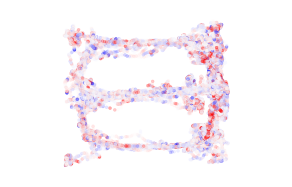

In [138]:
import matplotlib as mpl

# position_df_no_nan = position_df.query("not x.isnull()")
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)

fig, axs = plt.subplots(1,1, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor=None)

# plt.scatter(pos.data[0],pos.data[1],color="grey",s=1,rasterized=True)
plt.axis("equal")
plt.axis("off")

colors = np.interp(
    position_df_no_nan.time.values,
    assembly_act_task.abscissa_vals,
    assembly_act_task.data[5],
)
plt.scatter(
    pos.data[0],
    pos.data[1],
    s=2,
    c=colors,
    alpha=0.25,
    cmap="bwr",
    norm=norm,
    rasterized=True
)

plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_ratemap_pfc_deep_path_example.svg"),
    dpi=600,
    bbox_inches="tight",
    transparent=True
)

In [158]:
np.random.rand(10,10)

array([[0.64255571, 0.72083543, 0.38464334, 0.61221613, 0.40537423,
        0.14847726, 0.16354454, 0.42015175, 0.47129506, 0.89643034],
       [0.48888012, 0.38631297, 0.88810952, 0.13785137, 0.4959466 ,
        0.06197296, 0.13008672, 0.65389552, 0.26579236, 0.81185871],
       [0.97791385, 0.15079391, 0.65169391, 0.30775442, 0.83473069,
        0.83926128, 0.29462912, 0.86408149, 0.13135269, 0.9222911 ],
       [0.88965887, 0.49873257, 0.95182937, 0.6438517 , 0.78222362,
        0.6637576 , 0.6664512 , 0.05990999, 0.6880028 , 0.76234156],
       [0.35801374, 0.42778814, 0.3281636 , 0.85199319, 0.54715816,
        0.86748245, 0.43350408, 0.60046707, 0.53828426, 0.88816449],
       [0.77491146, 0.77598933, 0.67427778, 0.08991268, 0.73192777,
        0.50033487, 0.51548052, 0.09100054, 0.36610305, 0.03147851],
       [0.56698968, 0.99405493, 0.70216271, 0.52600911, 0.7836781 ,
        0.51483212, 0.99811006, 0.57470156, 0.31769982, 0.13485921],
       [0.68838816, 0.97336043, 0.5238936

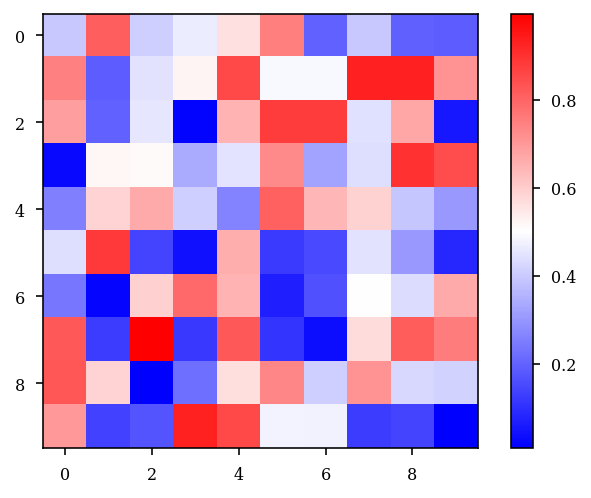

In [161]:
# plt.figure(figsize=(10,10))
# sns.color_palette("bwr",5, as_cmap=True)
plt.imshow(np.random.rand(10,10),cmap="bwr")
plt.colorbar()
plt.savefig(
    os.path.join(fig_save_path, "bwr_colorbar.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

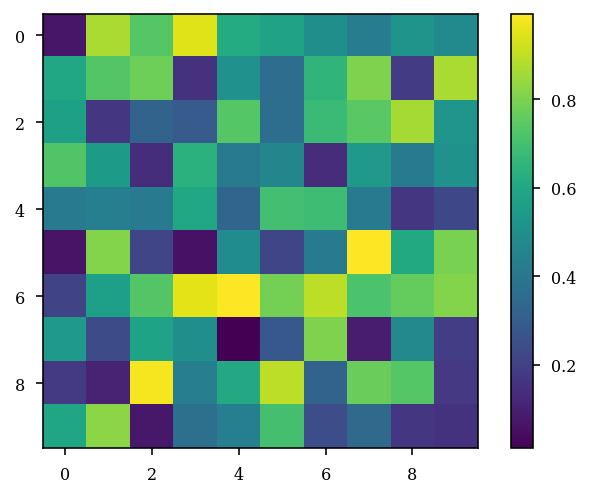

In [163]:
plt.imshow(np.random.rand(10,10),cmap="viridis")
plt.colorbar()
plt.savefig(
    os.path.join(fig_save_path, "viridis_colorbar.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

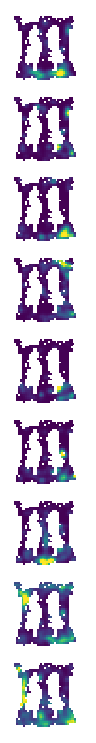

In [174]:

n_cells = assembly_df.query("assembly_n == 5 & is_member_sig").shape[0]

fig, axs = plt.subplots(n_cells,1, figsize=functions.set_size('thesis', fraction=.2, subplots=(n_cells, 1)), edgecolor='k')

for temp_df_i, temp_df in enumerate(assembly_df.query("assembly_n == 5 & is_member_sig").itertuples()):
    uid_idx = np.where(results["react"].cell_metrics.UID == temp_df.UID)[0][0]
    axs[temp_df_i].imshow(tc_unit[uid_idx],interpolation="nearest",vmax=np.nanmax(tc_unit[uid_idx])*.75)
    # plt.title(str(temp_df.UID) + temp_df.brainRegion)
    # plt.show()
    axs[temp_df_i].axis("off")

plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_ratemap_pfc_deep_individual_cells_example.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

In [85]:
assembly_act_task

<AnalogSignalArray at 0x298ba9000a0: 30 signals> for a total of 42:32:210 minutes

In [84]:
tc_assembly.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [ ]:
# plt.imshow(tc_other_method.ratemap[2])

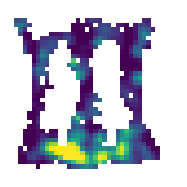

In [171]:
fig, axs = plt.subplots(1,1, figsize=functions.set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')

plt.imshow(tc_assembly[5],vmin=0,interpolation="nearest",vmax=.75)
plt.axis("off")
# plt.colorbar()
plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_ratemap_pfc_deep_example.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

<StemContainer object of 3 artists>

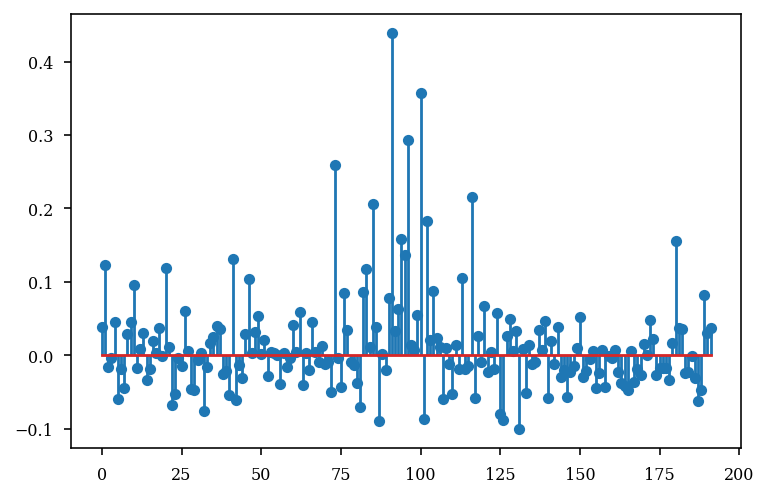

In [49]:
assembly_df.query("assembly_n == 5")
plt.stem(assembly_df.query("assembly_n == 5").patterns)

In [116]:
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)
patterns = results["react"].patterns

# is_member_sig = assembly_df.query("assembly_n == 5").is_member_sig.values
cm = results["react"].cell_metrics.copy()
cm.loc[cm.brainRegion.str.contains("CA1"),"brainRegion"] = "CA1"
cm.loc[cm.deepSuperficial.str.contains("middle"),"deepSuperficial"] = "Deep" # for example purposes, move to deep

cm["brainRegion_with_layer"] = cm.brainRegion + "_" + cm.deepSuperficial

idx = np.argsort(cm.brainRegion_with_layer.values)
patterns = patterns[:,idx]
is_member = is_member[:,idx]
cm = cm.iloc[idx]

group_colors = {
    "CA1_Deep": "#7b3294",
    "CA1_Superficial": "#008837",
    "CA1_middle": "#808080",
    "MEC_Cortical": "#de2020",
    "PFC_unknown": "#116f70",
}
# group_colors = {"deep": "#7b3294","sup": "#008837", "mixed": "grey"}

colors = np.tile(custom_plots.lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
for reg in group_colors.keys():
    # color by region
    idx = cm.brainRegion_with_layer.str.contains(reg).values
    colors[:,idx] = [group_colors[reg]] * sum(idx)
    # color by deep/sup
    # idx = cm.deepSuperficial.str.contains(reg).values
    # colors[:,idx] = [group_colors[reg]] * sum(idx)

for i in range(is_member.shape[0]): 
    for j in range(is_member.shape[1]):
        if is_member[i,j] != 1:
            colors[i,j] = custom_plots.lighten_color(colors[i,j],0.5)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [117]:
cm.brainRegion_with_layer.unique()

array(['CA1_Deep', 'CA1_Superficial', 'PFC_unknown'], dtype=object)

[Text(-0.5, 0, '-0.5'), Text(0.5, 0, '0.5')]

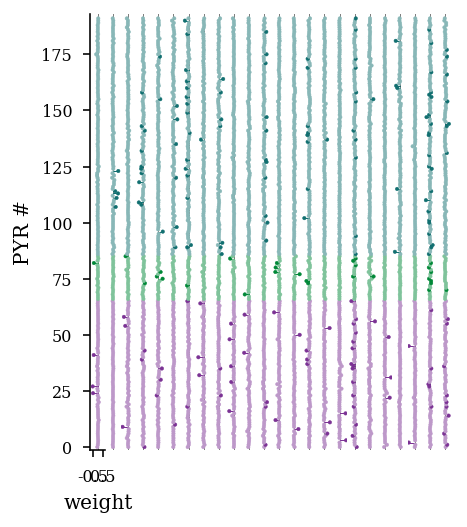

In [118]:
fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=.55, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors[i,:],zorder=1000,s=3,rasterized=True)

    # axs[i].scatter(assmbl,np.arange(len(assmbl)),zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[i,j],zorder=-50,linewidth=0.5,rasterized=True)

    axs[i].axvline(0,color='grey',zorder=-100,linewidth=0.5)

for i in range(patterns.shape[0]):
    axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].set_ylim(-1.5,patterns.shape[1]+1)

for i in range(patterns.shape[0]):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)  
    axs[i].patch.set_alpha(0)
    
for i in np.arange(1,patterns.shape[0]):
    axs[i].spines["left"].set_visible(False)  
    axs[i].spines["bottom"].set_visible(False)      
    axs[i].get_yaxis().set_ticks([])
    axs[i].get_xaxis().set_ticks([])

axs[0].set_ylabel('PYR #')
axs[0].set_xlabel('weight')
axs[0].set_xticks([-0.5,.5])
axs[0].set_xticklabels([-0.5,.5])

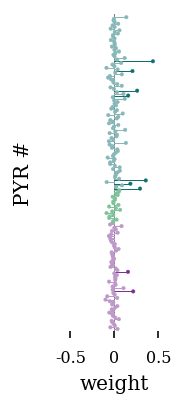

In [119]:
fig, axs = plt.subplots(1,1, figsize=functions.set_size('thesis', fraction=.2, subplots=(4, 1)), edgecolor='k')
# for i,assmbl in enumerate(patterns[4,:]):
i = 8 # 8 maps onto assembly 5 with the bad assemblies included
assmbl = patterns[i,:]
plt.scatter(assmbl,np.arange(len(assmbl)),c=colors[i,:],zorder=1000,s=3,rasterized=False)

    # plt.gca().scatter(assmbl,np.arange(len(assmbl)),zorder=1000,s=5)

for j,item in enumerate(assmbl):
    plt.plot(np.sort([item,0]),[j,j],color=colors[i,j],zorder=-50,linewidth=0.5,rasterized=False)

plt.axvline(0,color='grey',zorder=-100,linewidth=0.5)

plt.xlim(-patterns.max()-.1,patterns.max()+.1)
plt.ylim(-1.5,patterns.shape[1]+1)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)  
plt.gca().patch.set_alpha(0)
    
plt.gca().spines["left"].set_visible(False)  
plt.gca().spines["bottom"].set_visible(False)      
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticks([])

plt.gca().set_ylabel('PYR #')
plt.gca().set_xlabel('weight')
plt.gca().set_xticks([-0.5,0,.5])
plt.gca().set_xticklabels([-0.5,0,.5])

plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_weights_rate_map_ex.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True
)

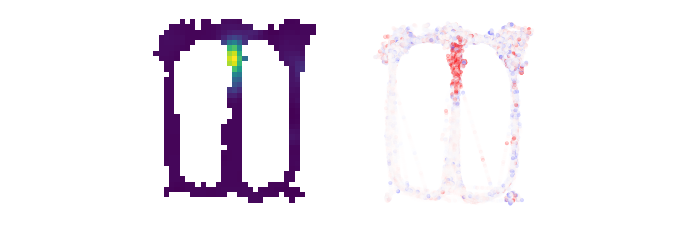

In [57]:

uu = 2

fig, axs = plt.subplots(1,2, figsize=functions.set_size('thesis', fraction=1, subplots=(1,2)), edgecolor=None)
fig.subplots_adjust(hspace = 0, wspace=-0.5)
ax = axs.ravel()

# fig, ax = plt.subplots(1, 2,figsize=functions.set_size("thesis", fraction=0.5, subplots=(1, 2)))
ax[0].imshow(tc.ratemap[uu, :, :], origin="lower")
# ax[0].colorbar()
ax[0].axis("equal")

colors = np.interp(
    position_df_no_nan.time.values,
    assembly_act_task.abscissa_vals,
    assembly_act_task.data[uu],
)
ax[1].scatter(
    position_df_no_nan.y,
    position_df_no_nan.x,
    s=3,
    c=colors,
    alpha=0.25,
    cmap="bwr",
    norm=norm,
    rasterized=True
)
ax[1].axis("equal")

ax[0].axis("off")
ax[1].axis("off")

# sns.despine(bottom=True,left=True)
plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_ratemap_example.svg"),
    dpi=300,
    bbox_inches="tight",
)

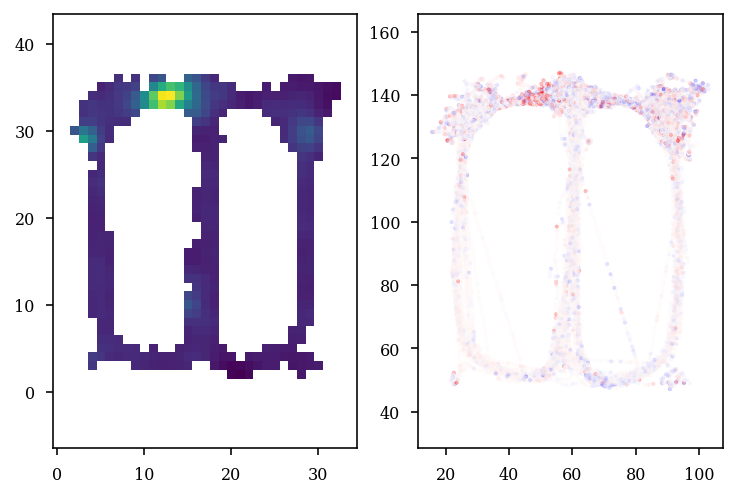

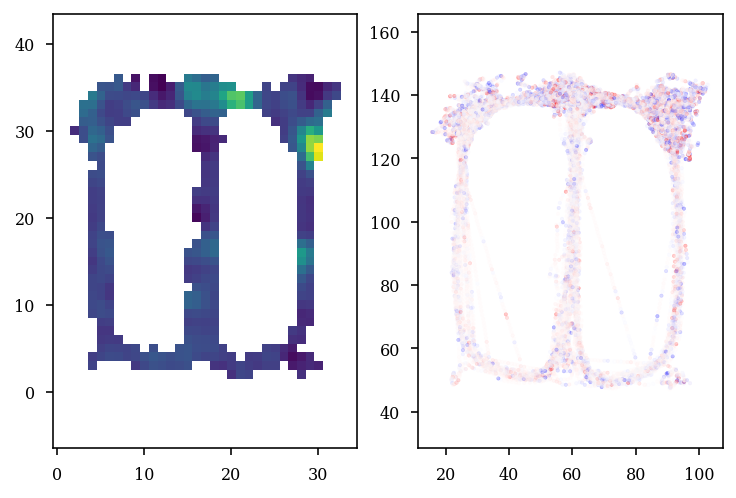

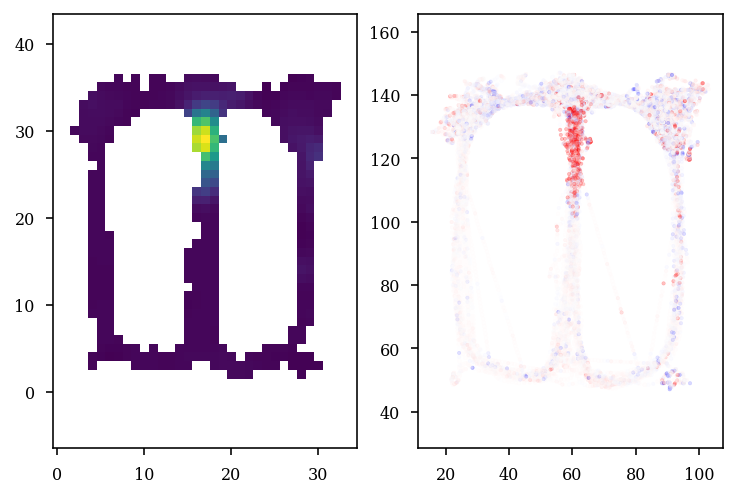

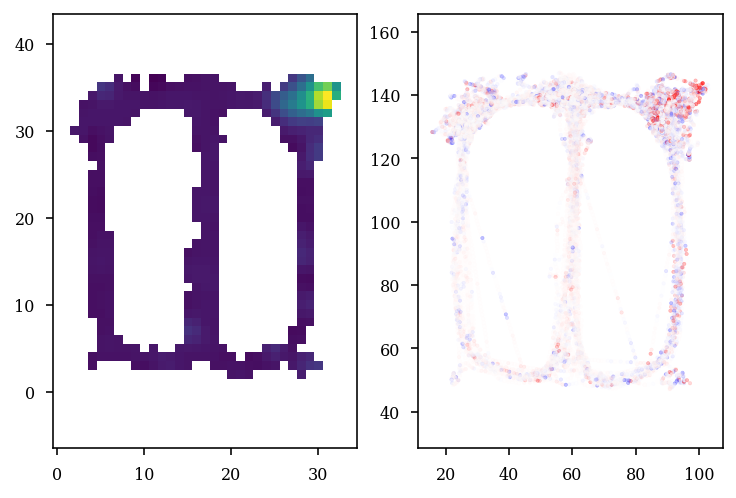

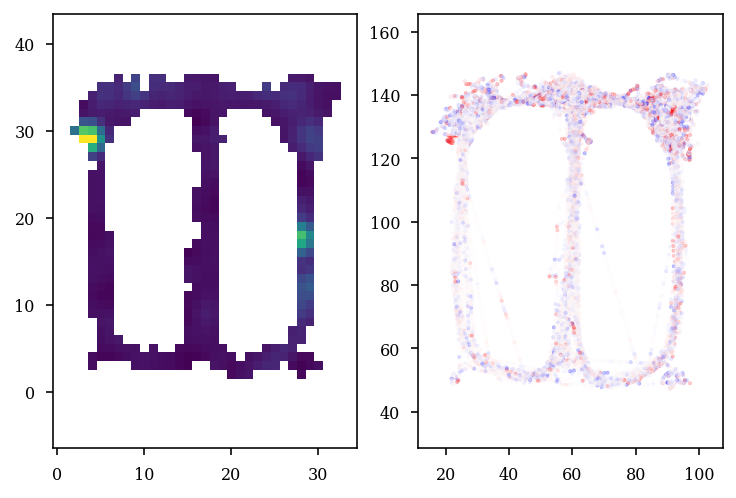

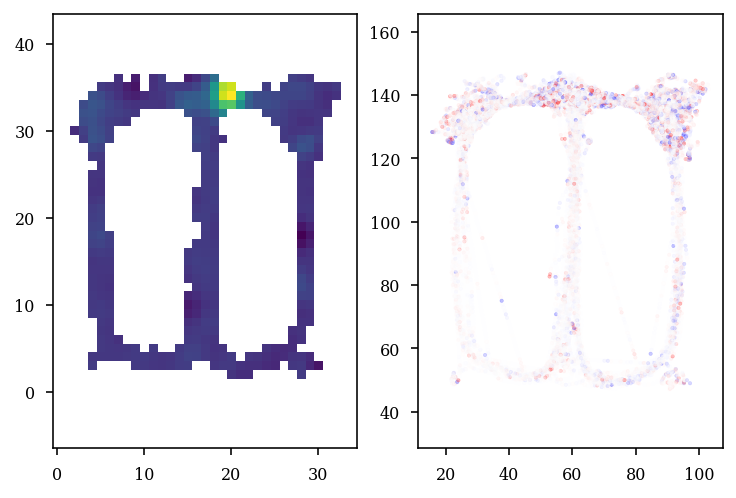

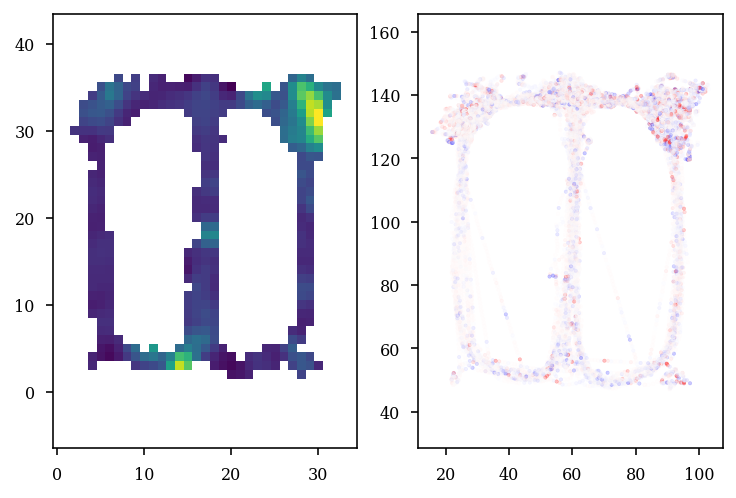

In [7]:
import matplotlib as mpl

position_df_no_nan = position_df.query("not x.isnull()")
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)

for uu in range(assembly_act_task.n_signals):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(tc.ratemap[uu, :, :], origin="lower")
    # ax[0].colorbar()
    ax[0].axis("equal")

    colors = np.interp(
        position_df_no_nan.time.values,
        assembly_act_task.abscissa_vals,
        assembly_act_task.data[uu],
    )
    ax[1].scatter(
        position_df_no_nan.y,
        position_df_no_nan.x,
        s=3,
        c=colors,
        alpha=0.25,
        cmap="bwr",
        norm=norm,
    )
    ax[1].axis("equal")

## scratch code to make hist of deep sup tracing

In [16]:
deep_sup_hist = pd.read_csv(r"C:\Users\Cornell\Downloads\deep_sup_hist.csv")
deep_sup_hist

,mcherry_norm,mcherry_rela,Unnamed: 2,egfp_norm,egfp_rela
0,0.082190,6.863,NaN,0.410960,34.316
1,0.165625,13.830,NaN,0.541724,45.235
2,0.013700,1.144,NaN,0.760904,63.537
3,0.053556,4.472,NaN,0.183061,15.286
4,0.103363,8.631,NaN,0.870494,72.688
...,...,...,...,...,...
459,0.262405,20.751,NaN,NaN,NaN
460,0.398571,31.519,NaN,NaN,NaN
461,0.262405,20.751,NaN,NaN,NaN
462,0.262405,20.751,NaN,NaN,NaN


(array([2.15244444, 2.69937704, 1.94072859, 0.75864845, 0.38814572,
        0.1411439 , 0.03528597, 0.01764299, 0.03528597, 0.01764299]),
 array([0.        , 0.12215462, 0.24430924, 0.36646386, 0.48861848,
        0.6107731 , 0.73292773, 0.85508235, 0.97723697, 1.09939159,
        1.22154621]),
 <BarContainer object of 10 artists>)

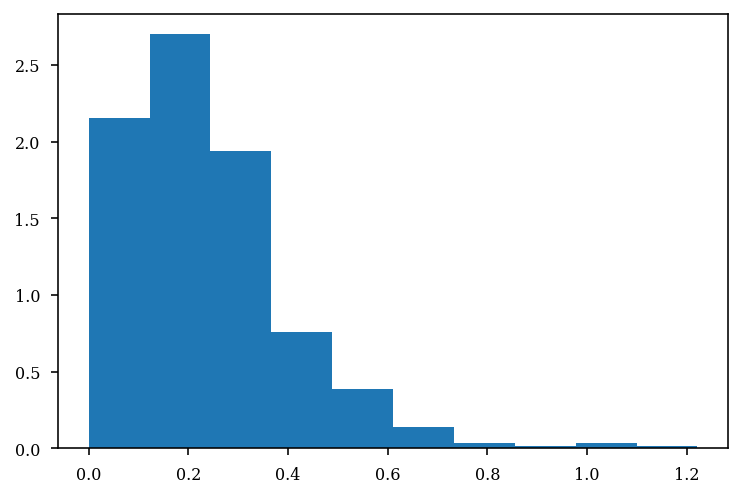

In [19]:
plt.hist(deep_sup_hist.mcherry_norm,density=True)

In [24]:
deep_sup_hist.mcherry_norm.min()

0.0

(-0.5, 1.5)

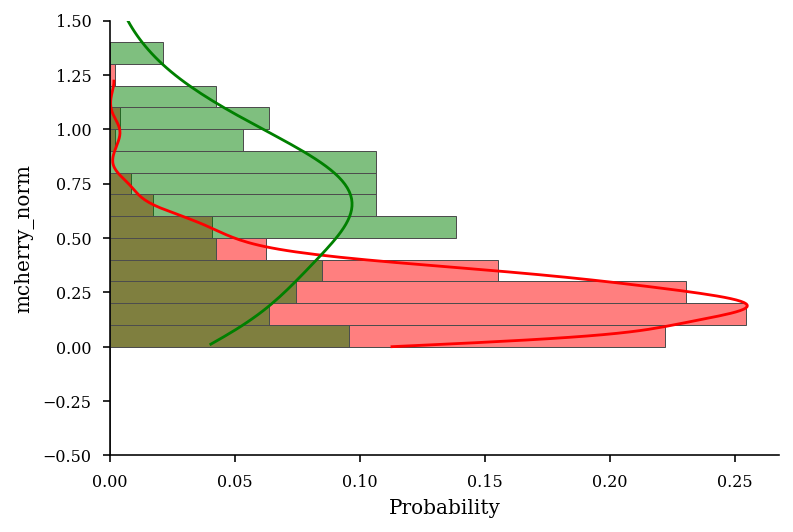

In [40]:
bins = np.arange(-.5,1.5,.1)
sns.histplot(
    deep_sup_hist,
    y="mcherry_norm",
    edgecolor=".3",
    linewidth=.5,
    kde=True,
    color="red",
    bins=bins,
    stat="probability"
)
sns.histplot(
    deep_sup_hist,
    y="egfp_norm",
    edgecolor=".3",
    linewidth=.5,
    kde=True,
    color="green",
    bins=bins,
    stat="probability"
)
sns.despine()
plt.ylim(-.5,1.5)